In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory #, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

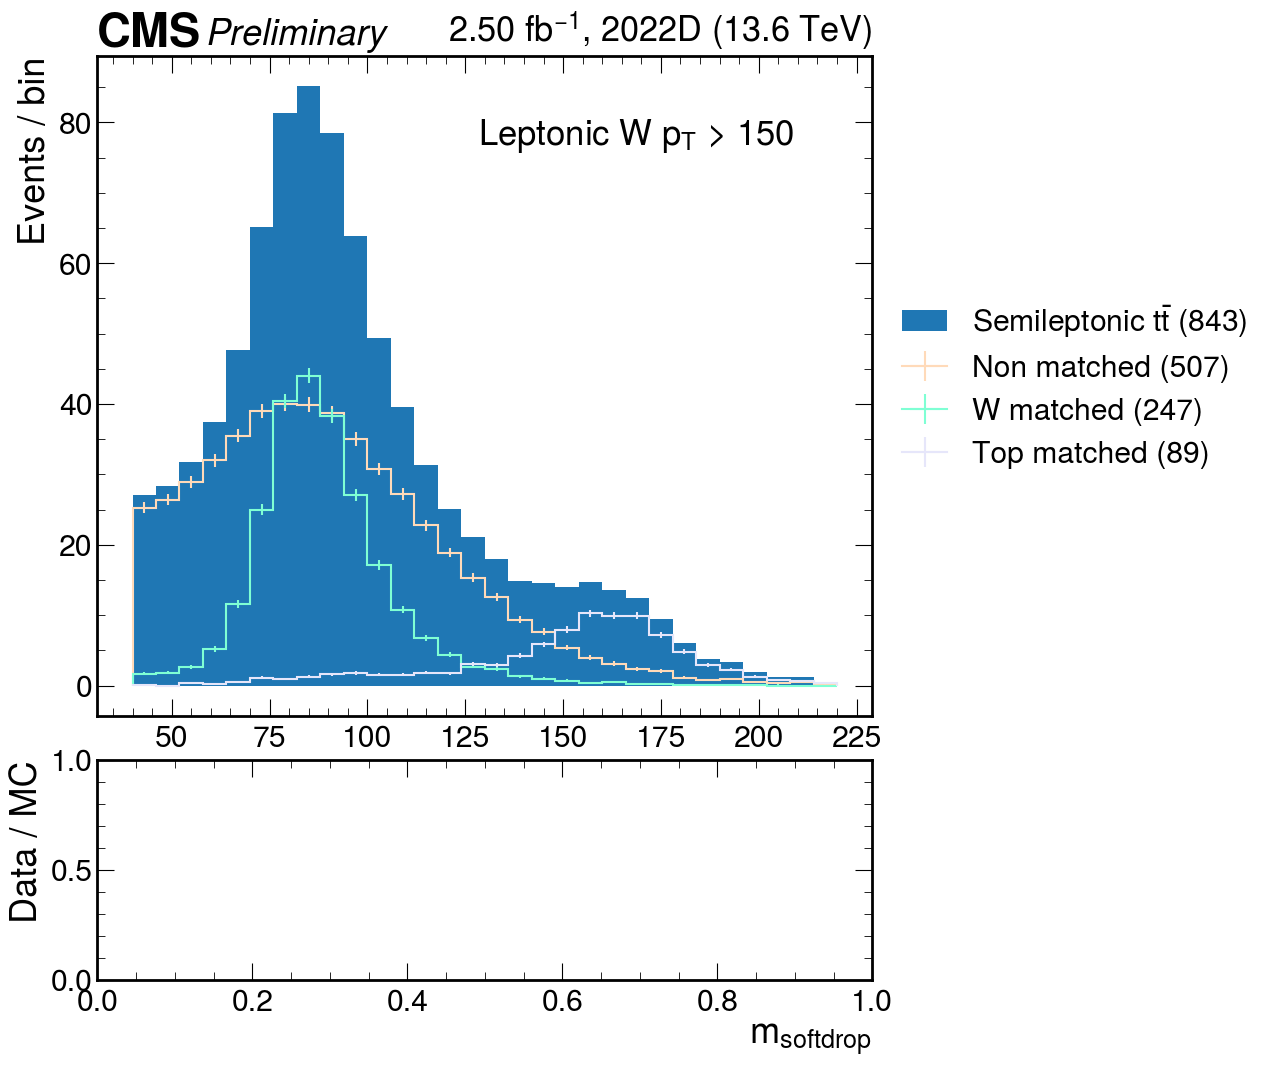

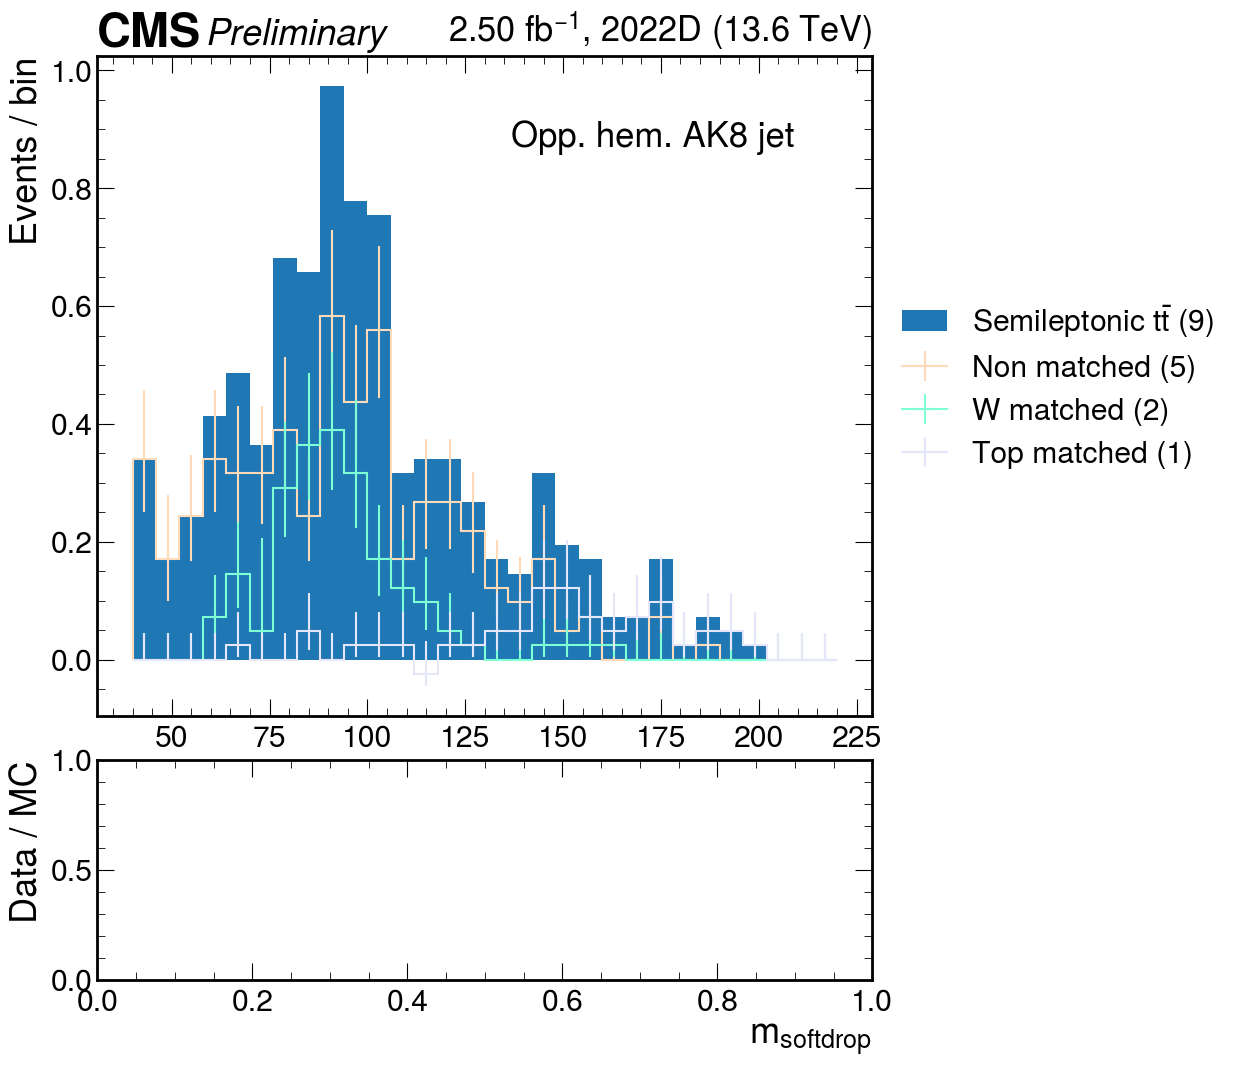

In [6]:
from coffea.hist import clopper_pearson_interval, poisson_interval

mc = util.load("outfiles/Run3Summer22/lumi100isoTrack/cutflow_TTtoLNu2Q_isoTrack.coffea")

lumis = {
    "2022d" : 100 #986.530469663
}
xs = {
    "TTtoLNu2Q" : 762.1,
    "QCD" : 222.1,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
    'Muon track dz',
]

scale_lumi_mc = {k: xs[k] * lumis[era] / w for k, w in mc['sumw'].items()}

h_mc = mc["cutflow"][{
    "pn_Hbb" : slice(0j, 1j, sum),
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi_mc[name]

    
for i in [5, 7]: #h_mc.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 12), gridspec_kw={"height_ratios": (3, 1)}, sharex=False
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / bin")
    rax.set_ylabel("Data / MC")
    rax.set_xlabel(r"m$_{softdrop}$")
    ax.set_xlabel(" ")
    
    hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i)}]
    
    mplhep.histplot(
        [
            hh_mc[{"cat" : sum}],
        ],
        ax=ax, 
        histtype="fill",
        label=[
            r"Semileptonic $t\bar{t}$" + f" ({hh_mc.sum().value:,.0f})",
        ],
        stack=True,
        sort="y_r",
    )
    
    mplhep.histplot(
        [
            hh_mc[{"cat" : hist.loc(3)}],
            hh_mc[{"cat" : hist.loc(2)}],
            hh_mc[{"cat" : hist.loc(1)}],
        ],
        ax=ax,
        label=[
            "Non matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc(3)}].sum().value),
            "W matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc(2)}].sum().value),
            "Top matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc(1)}].sum().value),
        ],
        color=["peachpuff","aquamarine","lavender"]
    )
    
    rax.axhline(1, color='gray',ls='--')
    
    plt.text(0.9, 0.85, f"{cuts[i]}",
                fontsize=25,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    mplhep.cms.label(
            ax=ax, 
            data=True, 
            label="Preliminary",
            year="2022D",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
        )
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

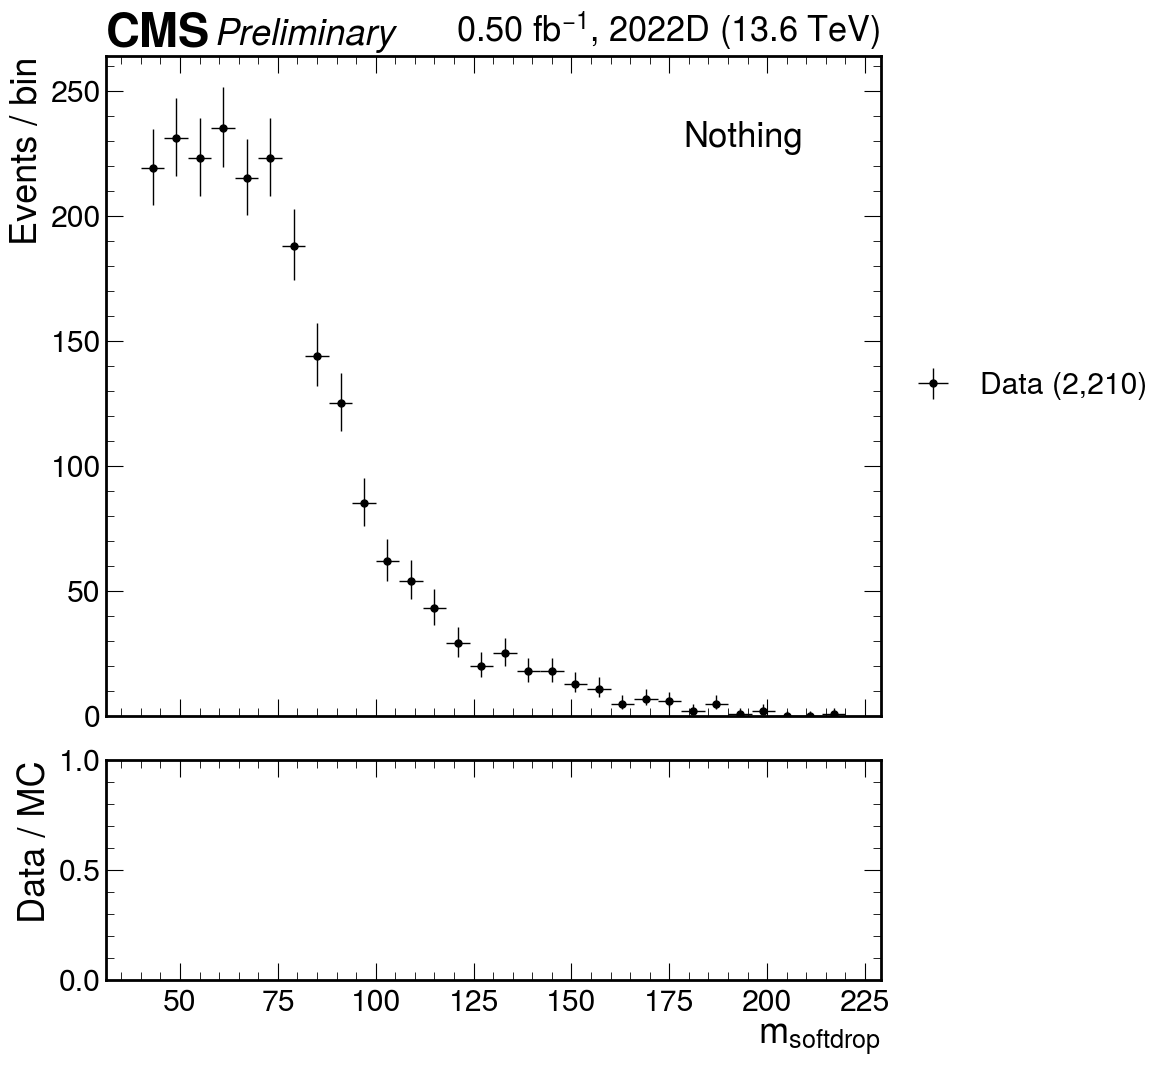

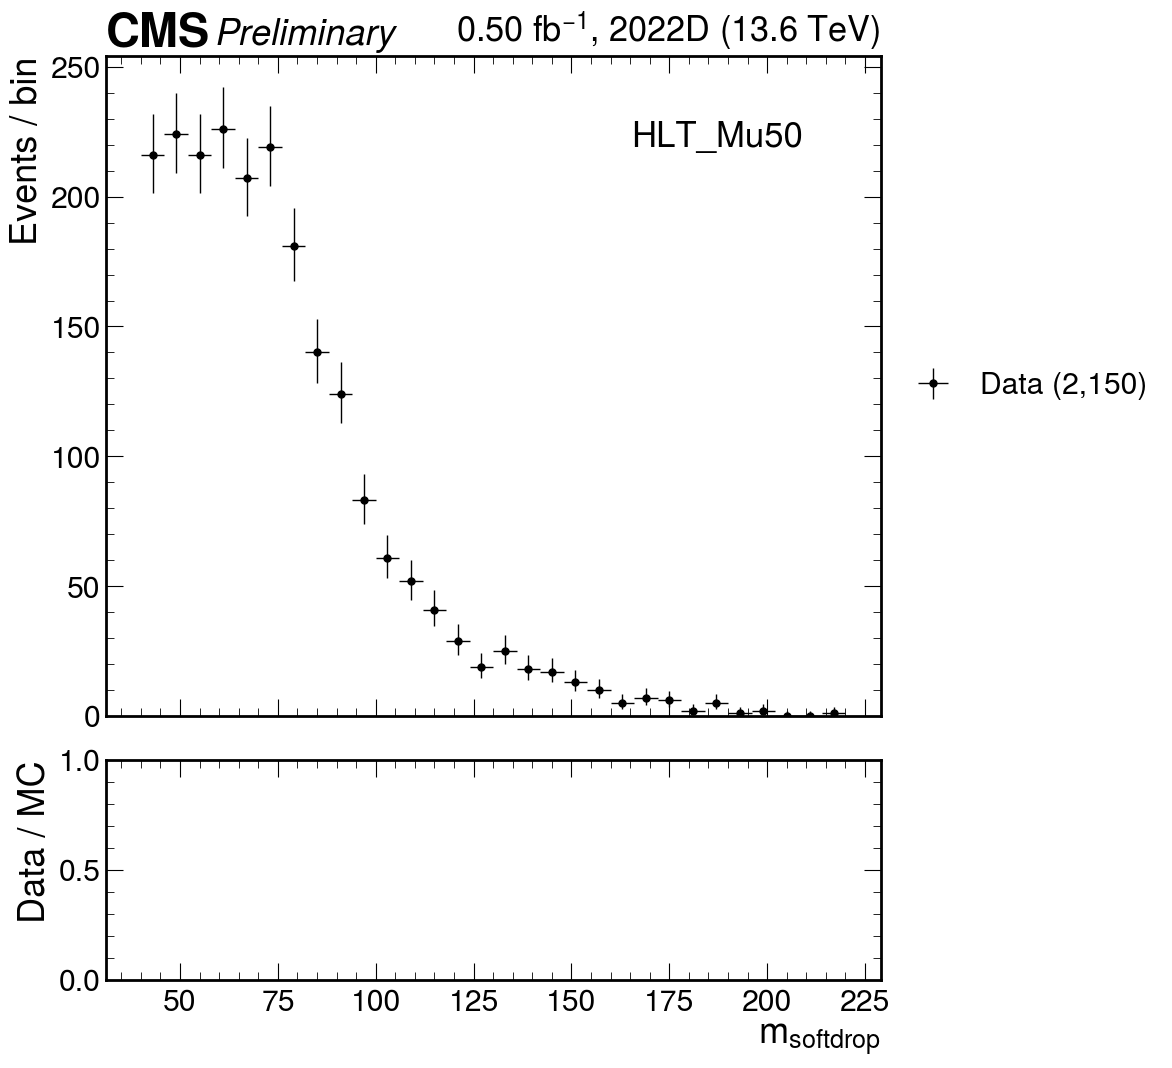

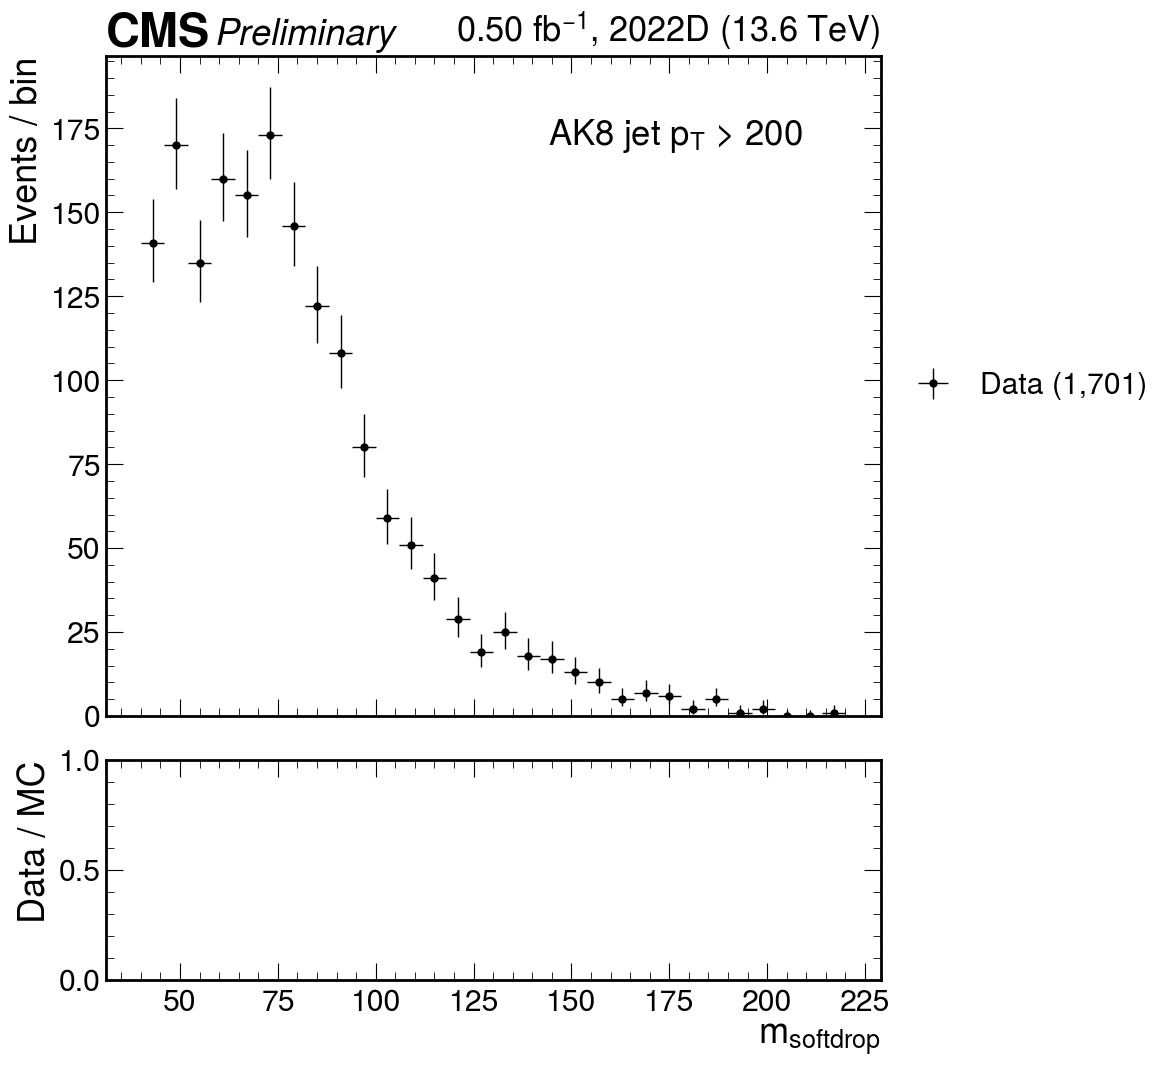

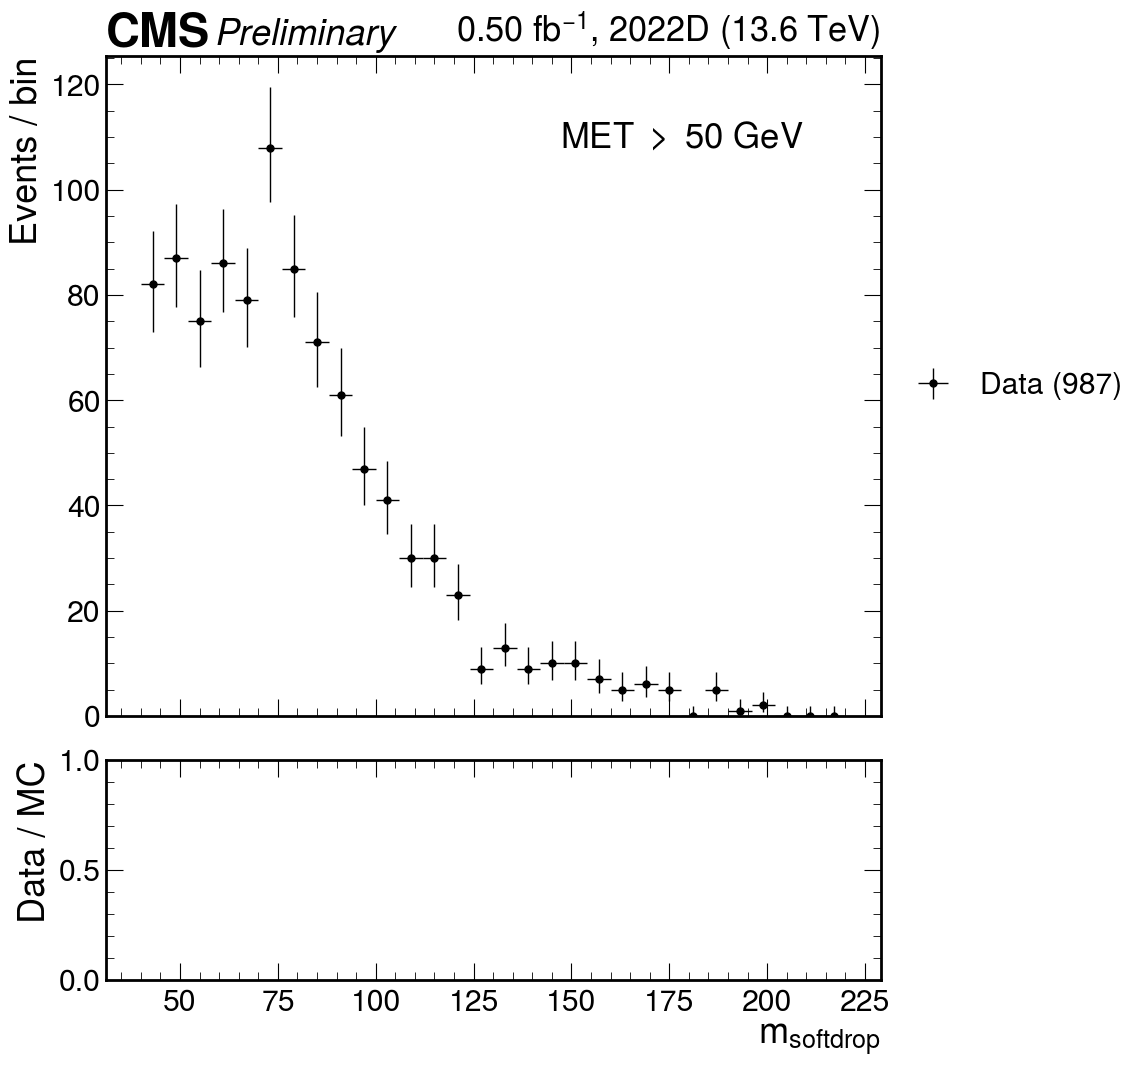

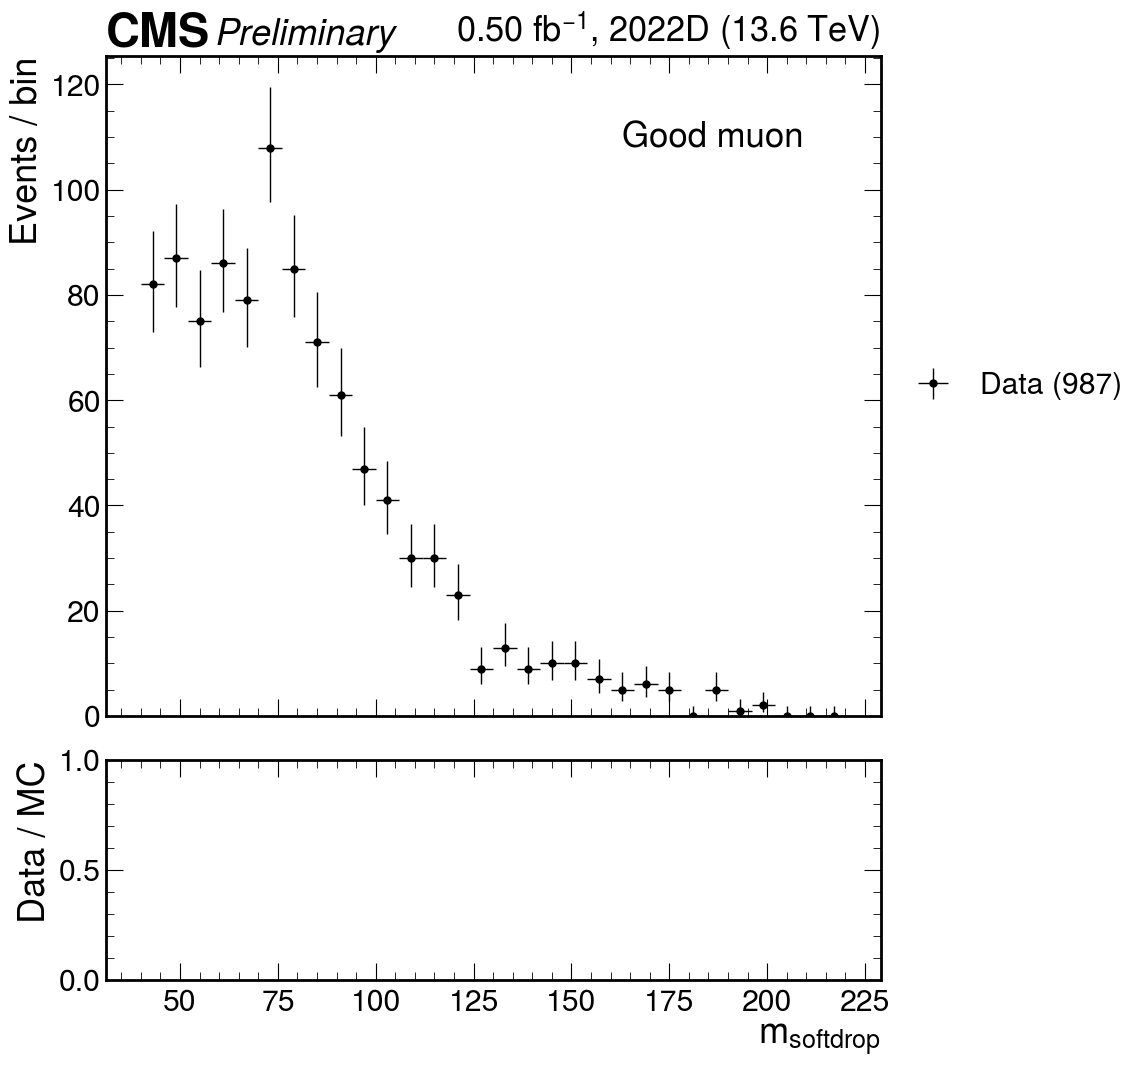

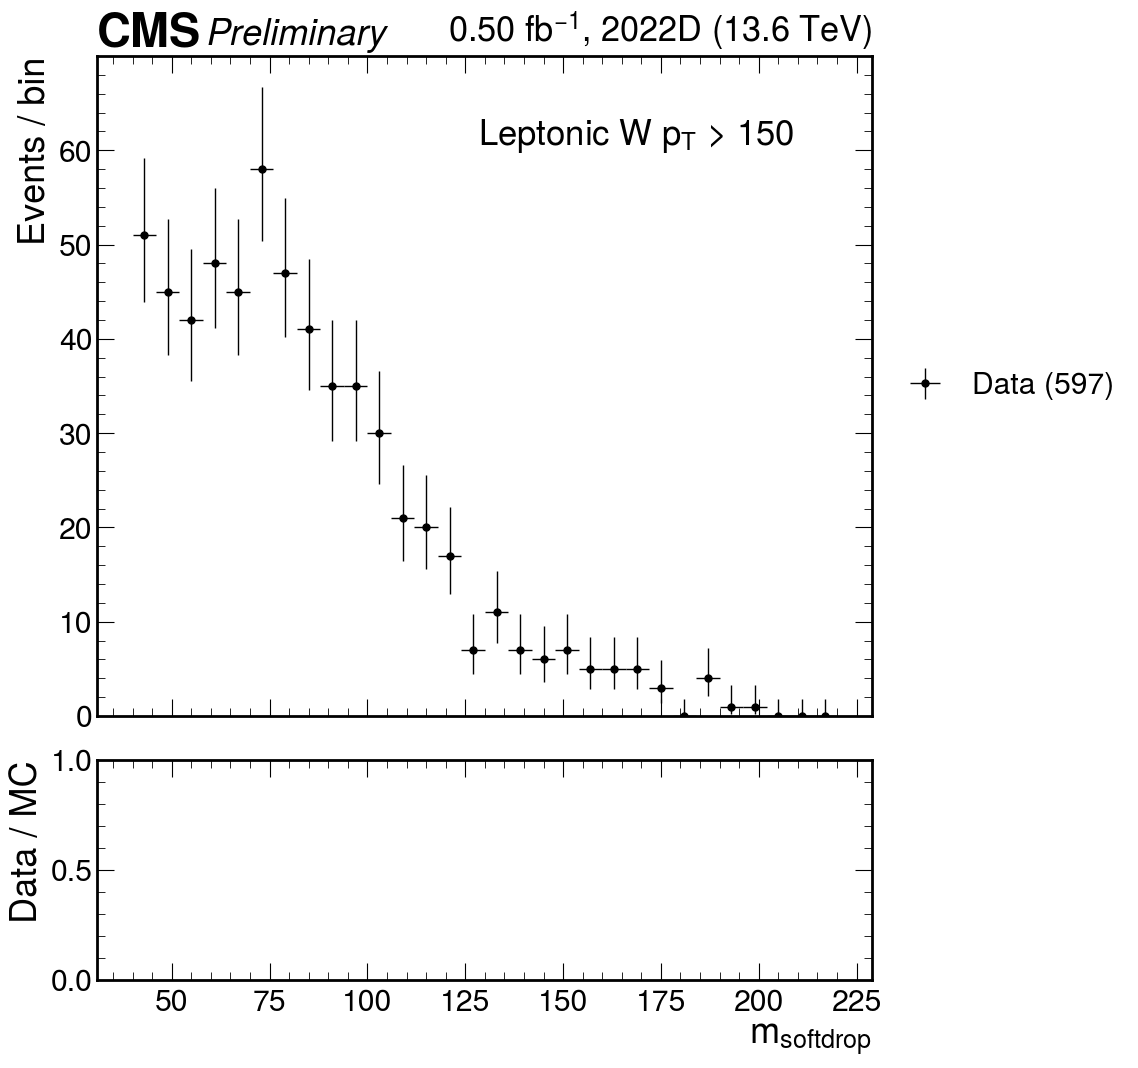

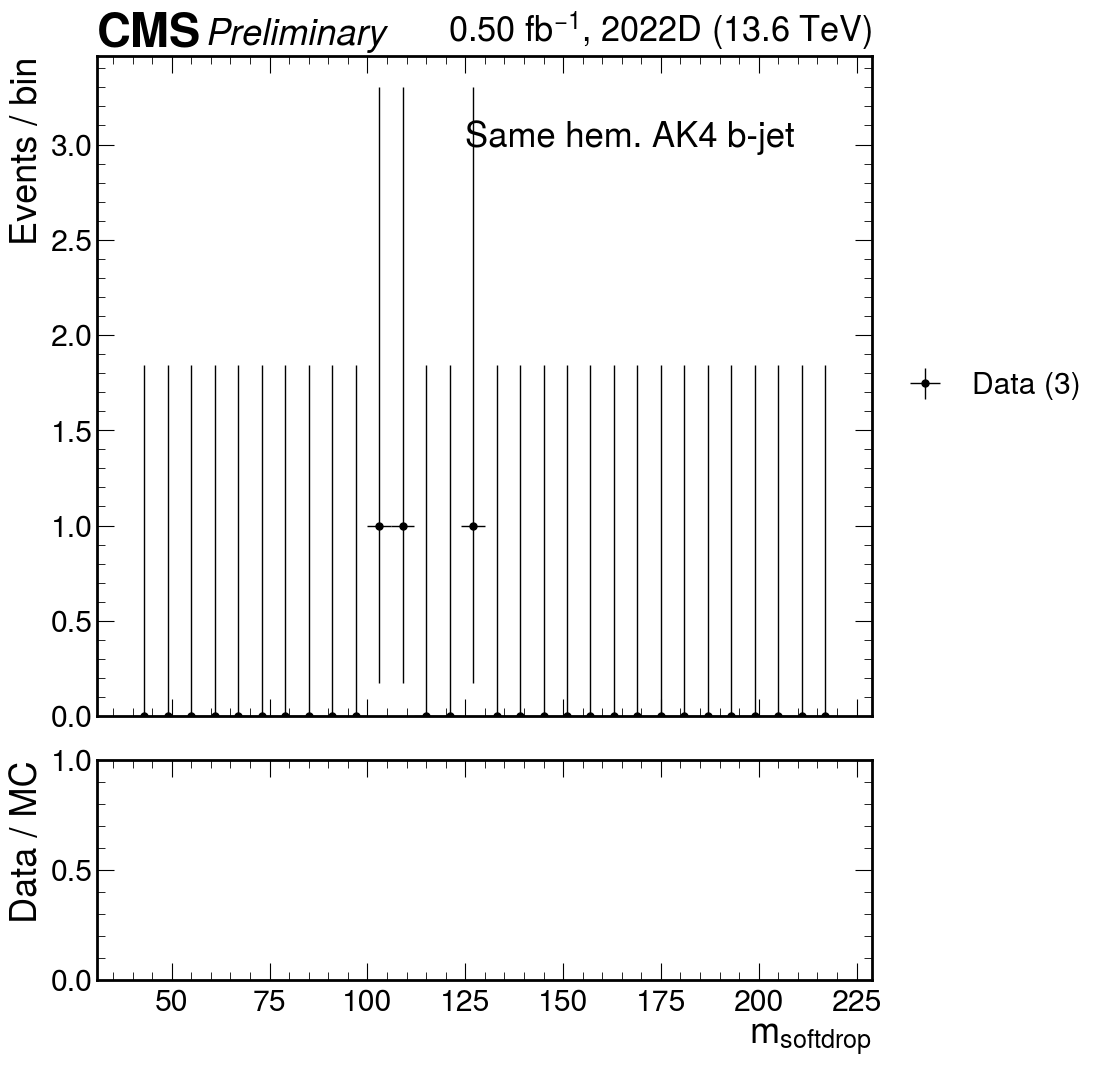

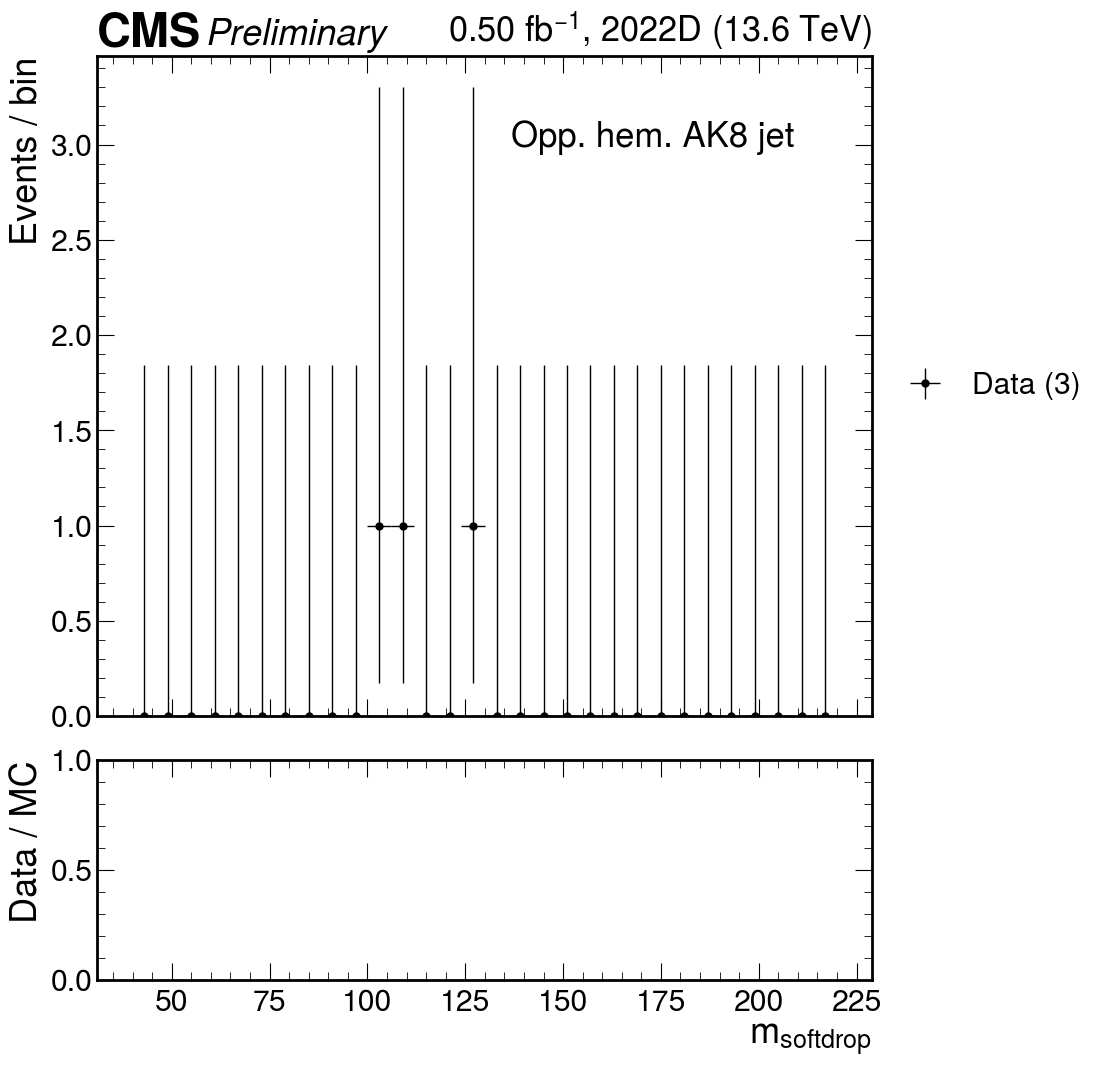

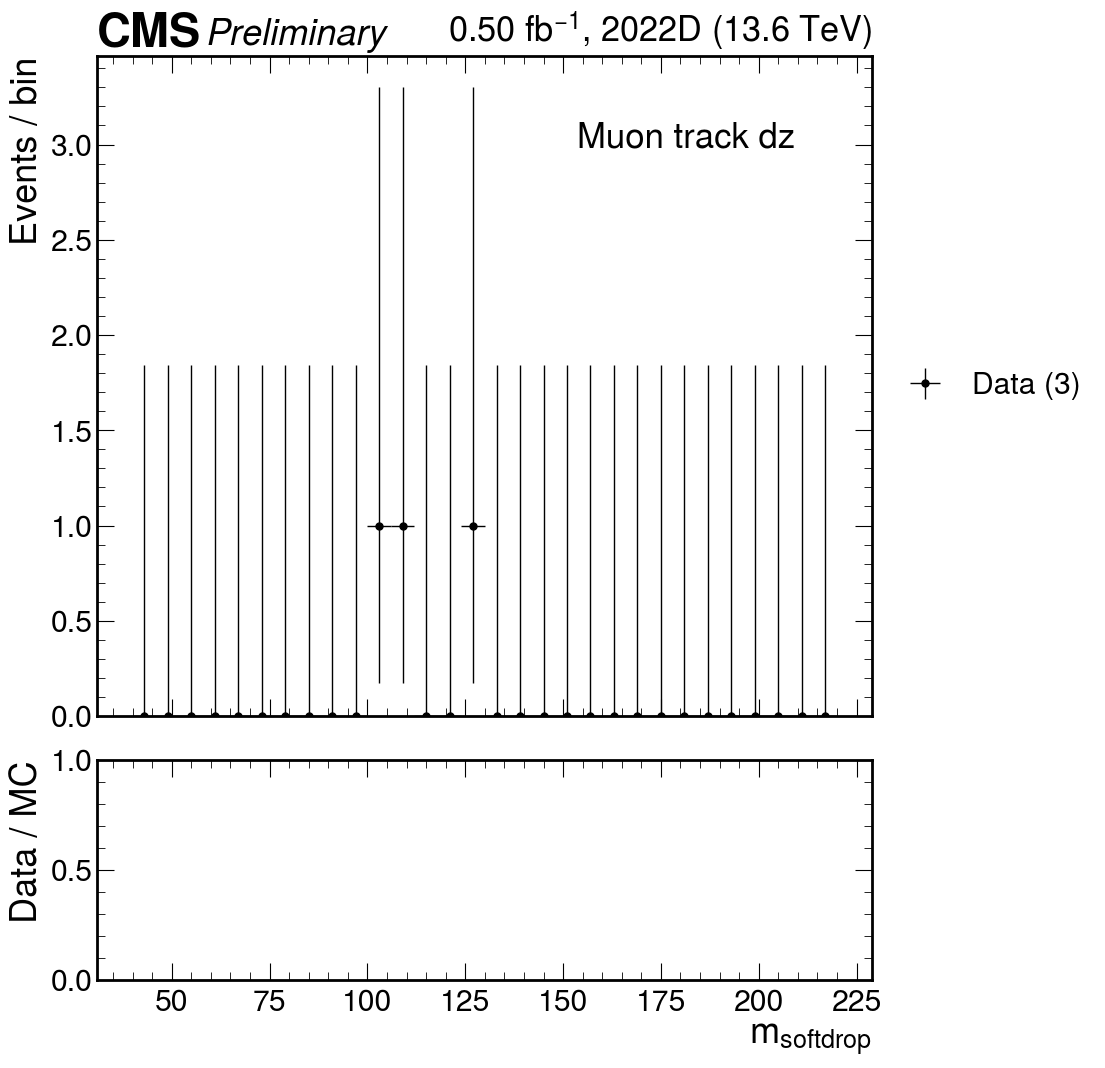

In [25]:
from coffea.hist import clopper_pearson_interval, poisson_interval

data = util.load("outfiles/Run3Summer22/fulllumi/nminus1_Run2022D_jetId_btag0p1.coffea")[0]

lumis = {
    "2022d" :  500 #1624.917355479 #986.530469663 #624.905199074
}
xs = {
    "TTtoLNu2Q" : 762.1,
    "QCD" : 222.1,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
    'Muon track dz',
]

h_data = data["cutflow"][{
    "pn_Hbb" : slice(0j, 1j, sum),
    "cat" : sum,
    "region" : hist.loc("all"),
    "dataset" : sum
}]
    
for i in h_data.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 12), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / bin")
    rax.set_ylabel("Data / MC")
    rax.set_xlabel(r"m$_{softdrop}$")
    ax.set_xlabel(" ")
    
    hh_data = h_data[{"cut" : hist.loc(i)}]
    
    mplhep.histplot(
        hh_data, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="black",
        label=f"Data ({hh_data.sum().value:,.0f})"
    )
    
    rax.axhline(1, color='gray',ls='--')
    
    plt.text(0.9, 0.85, f"{cuts[i]}",
                fontsize=25,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    mplhep.cms.label(
            ax=ax, 
            data=True, 
            label="Preliminary",
            year="2022D",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
        )
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [67]:
util.load("outfiles/Run3Summer22/fulllumi/nminus1_Run2022D_jetId_btag0p1.coffea")[0]

{'sumw': defaultdict(float, {}),
 'events': defaultdict(int, {'Run2022D': 79927405}),
 'passtrig': defaultdict(int, {'Run2022D': 2299469}),
 'cutflow': Hist(
   StrCategory(['Run2022D'], growth=True, name='dataset', label='Dataset'),
   StrCategory(['all'], growth=True, name='region', label='Region'),
   IntCategory([-1], growth=True, name='cat', label='Category'),
   Regular(30, 40, 220, name='msoftdrop'),
   Regular(30, 0, 1, name='pn_Hbb', label='H(bb) vs QCD score'),
   IntCategory([0, 1, 2, 3, 4, 5, 6, 7, 8], growth=True, name='cut', label='Cut Idx'),
   storage=Weight()) # Sum: WeightedSum(value=8641, variance=8641) (WeightedSum(value=8.3084e+07, variance=8.3084e+07) with flow),
 'hltmu50': Hist(
   StrCategory([], growth=True, name='dataset', label='Dataset'),
   StrCategory([], growth=True, name='region', label='Region'),
   IntCategory([], growth=True, name='hltmu50', label='HLT Muon 50'),
   IntCategory([], growth=True, name='cat', label='Category'),
   storage=Weight()) # Su

In [68]:
infiles = ["nminus1_Run2022C_jetId_btag0p1.coffea", "nminus1_Run2022D_jetId_btag0p1.coffea"] #, "nminus1_TTtoLNu2Q_isoTrack_jetId_btag0p1.coffea"]
outsum = defaultdict()

started = 0
for file in infiles:
    
    filename = "outfiles/Run3Summer22/fulllumi/"+file

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)[0]

        if started == 0:
            outsum['templates'] = out['cutflow']
            outsum['sumw'] = out['sumw']
            started += 1
        else:
            outsum['templates'] += out['cutflow']
            for k,v in out['sumw'].items():
                outsum['sumw'][k] = v
        del out

Loading outfiles/Run3Summer22/fulllumi/nminus1_Run2022C_jetId_btag0p1.coffea
Loading outfiles/Run3Summer22/fulllumi/nminus1_Run2022D_jetId_btag0p1.coffea


In [69]:
outsum

defaultdict(None,
            {'templates': Hist(
               StrCategory(['Run2022C', 'Run2022D'], growth=True, name='dataset', label='Dataset'),
               StrCategory(['all'], growth=True, name='region', label='Region'),
               IntCategory([-1], growth=True, name='cat', label='Category'),
               Regular(30, 40, 220, name='msoftdrop'),
               Regular(30, 0, 1, name='pn_Hbb', label='H(bb) vs QCD score'),
               IntCategory([0, 1, 2, 3, 4, 5, 6, 7, 8], growth=True, name='cut', label='Cut Idx'),
               storage=Weight()) # Sum: WeightedSum(value=11834, variance=11834) (WeightedSum(value=1.74633e+09, variance=1.74633e+09) with flow),
             'sumw': defaultdict(float, {})})

In [70]:
def group(h: hist.Hist, oldname: str, newname: str, grouping: dict):
    hnew = hist.Hist(
        hist.axis.StrCategory(grouping, name=newname),
        *(ax for ax in h.axes if ax.name != oldname),
        storage=h._storage_type,
    )
    for i, indices in enumerate(grouping.values()):
        hnew.view(flow=True)[i] = h[{oldname: indices}][{oldname: sum}].view(flow=True)

    return hnew

In [73]:
grouping = {
    "Run3Summer22": ["Run2022C", "Run2022D"],
}

data = group(outsum["templates"], "dataset", "process", grouping)

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


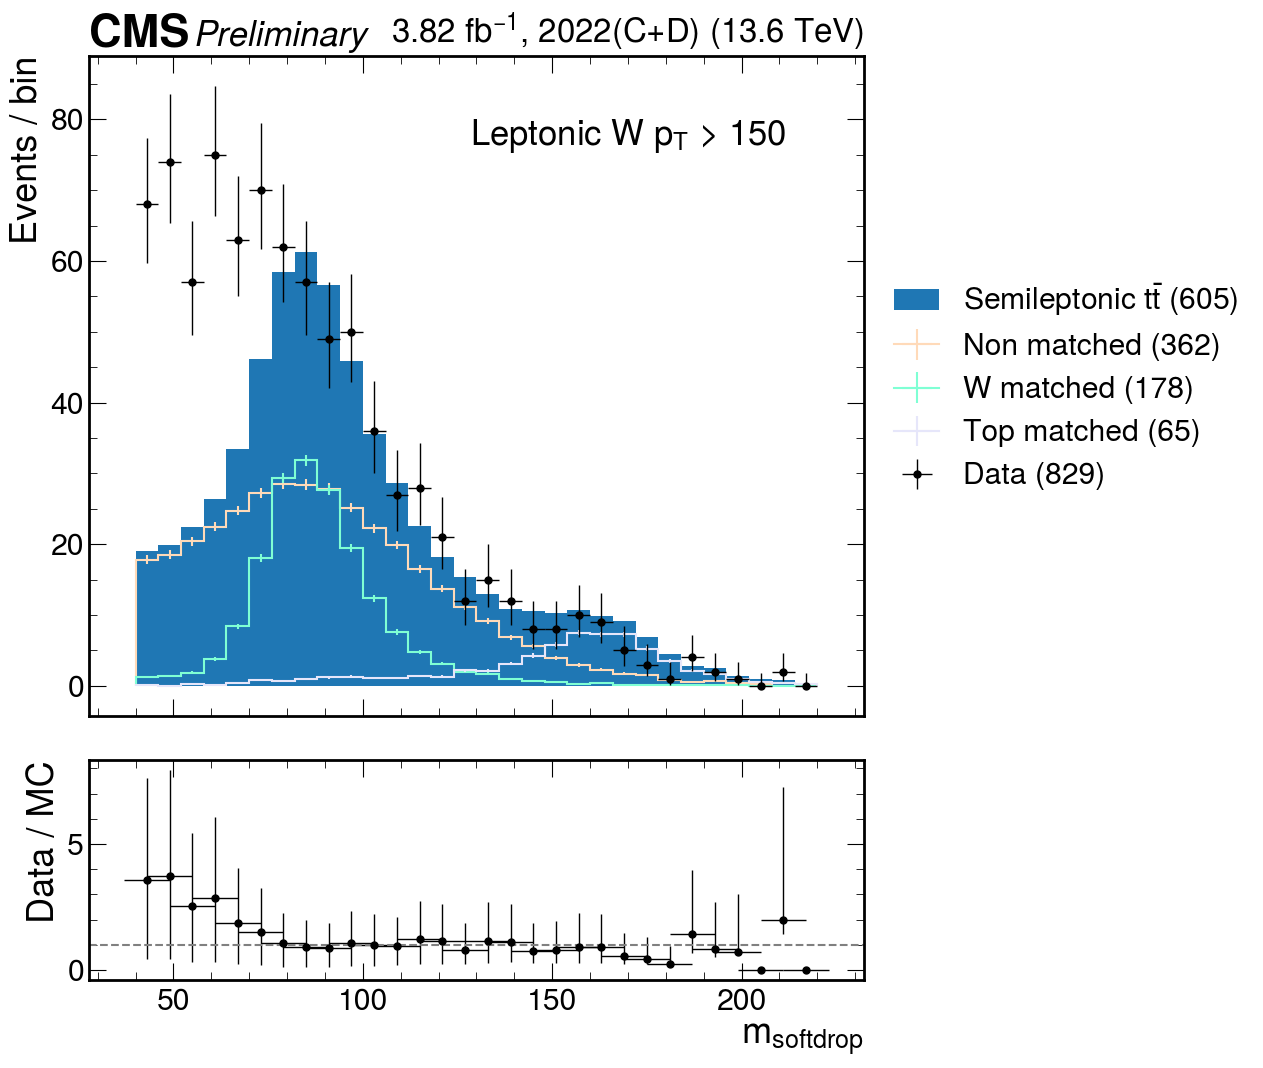

In [88]:
from coffea.hist import clopper_pearson_interval, poisson_interval

#data = util.load("outfiles/Run3Summer22/fulllumi/nminus1_Run2022C_jetId_btag0p1.coffea")[0]
mc = util.load("outfiles/Run3Summer22/fulllumi/nminus1_TTtoLNu2Q_isoTrack_jetId_btag0p1.coffea")[0]

lumis = {
    "2022d" :  3820.82926407 #1179.99079713  #2640.83846694
}

scale = 0.47837295482 #0.45444947223 #0.48906250969

xs = {
    "TTtoLNu2Q" : 762.1,
    "QCD" : 222.1,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
    'Muon track dz',
]

scale_lumi_mc = {k: xs[k] * lumis[era] * scale / w for k, w in mc['sumw'].items()}

h_data = data[{
    "pn_Hbb" : slice(0j, 1j, sum),
    "cat" : sum,
    "process" : sum,
    "region" : hist.loc("all")
}]
h_mc = mc["cutflow"][{
    "pn_Hbb" : slice(0j, 1j, sum),
    "region" : hist.loc("all")
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi_mc[name]

    
for i in [5]: #h_data.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 12), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / bin")
    rax.set_ylabel("Data / MC")
    rax.set_xlabel(r"m$_{softdrop}$")
    ax.set_xlabel(" ")
    
    hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i)}]
    
    mplhep.histplot(
        [
            hh_mc[{"cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}],
        ],
        ax=ax, 
        histtype="fill",
        label=[
            r"Semileptonic $t\bar{t}$" + f" ({hh_mc.sum().value:,.0f})",
        ],
        stack=True,
        sort="y_r",
    )
    
    mplhep.histplot(
        [
            hh_mc[{"cat" : hist.loc(3)}],
            hh_mc[{"cat" : hist.loc(2)}],
            hh_mc[{"cat" : hist.loc(1)}],
        ],
        ax=ax,
        label=[
            "Non matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc(3)}].sum().value),
            "W matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc(2)}].sum().value),
            "Top matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc(1)}].sum().value),
        ],
        color=["peachpuff","aquamarine","lavender"]
    )
    
    hh_data = h_data[{"cut" : hist.loc(i)}]
    
    mplhep.histplot(
        hh_data, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="black",
        label=f"Data ({hh_data.sum().value:,.0f})"
    )
    
    centers = hh_data.axes[0].centers
    sumw_num, sumw2_num = hh_data.values(), hh_data.variances()
    sumw_denom, sumw2_denom = hh_mc[{"cat" : sum}].values(), hh_mc[{"cat" : sum}].variances()
    
    rsumw = sumw_num / np.maximum(1, sumw_denom)
    rsumw_unc = poisson_interval(
        rsumw,
        sumw2_num / sumw_denom**2
    )
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }
    
    rax.errorbar(
        centers,
        rsumw,
        xerr=centers[1]-centers[0],
        yerr=rsumw_unc,
        **data_err_opts,
    )
    
    rax.axhline(1, color='gray',ls='--')
    
    plt.text(0.9, 0.85, f"{cuts[i]}",
                fontsize=25,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    mplhep.cms.label(
            ax=ax, 
            data=True, 
            fontsize=25,
            label="Preliminary",
            year="2022(C+D)",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
        )
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/opt/conda/lib/python3.8/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/tmp/ipykernel_28/1445889281.py:117: RuntimeWarning: invalid value encountered in divide
  sumw2_num / sumw_denom**2


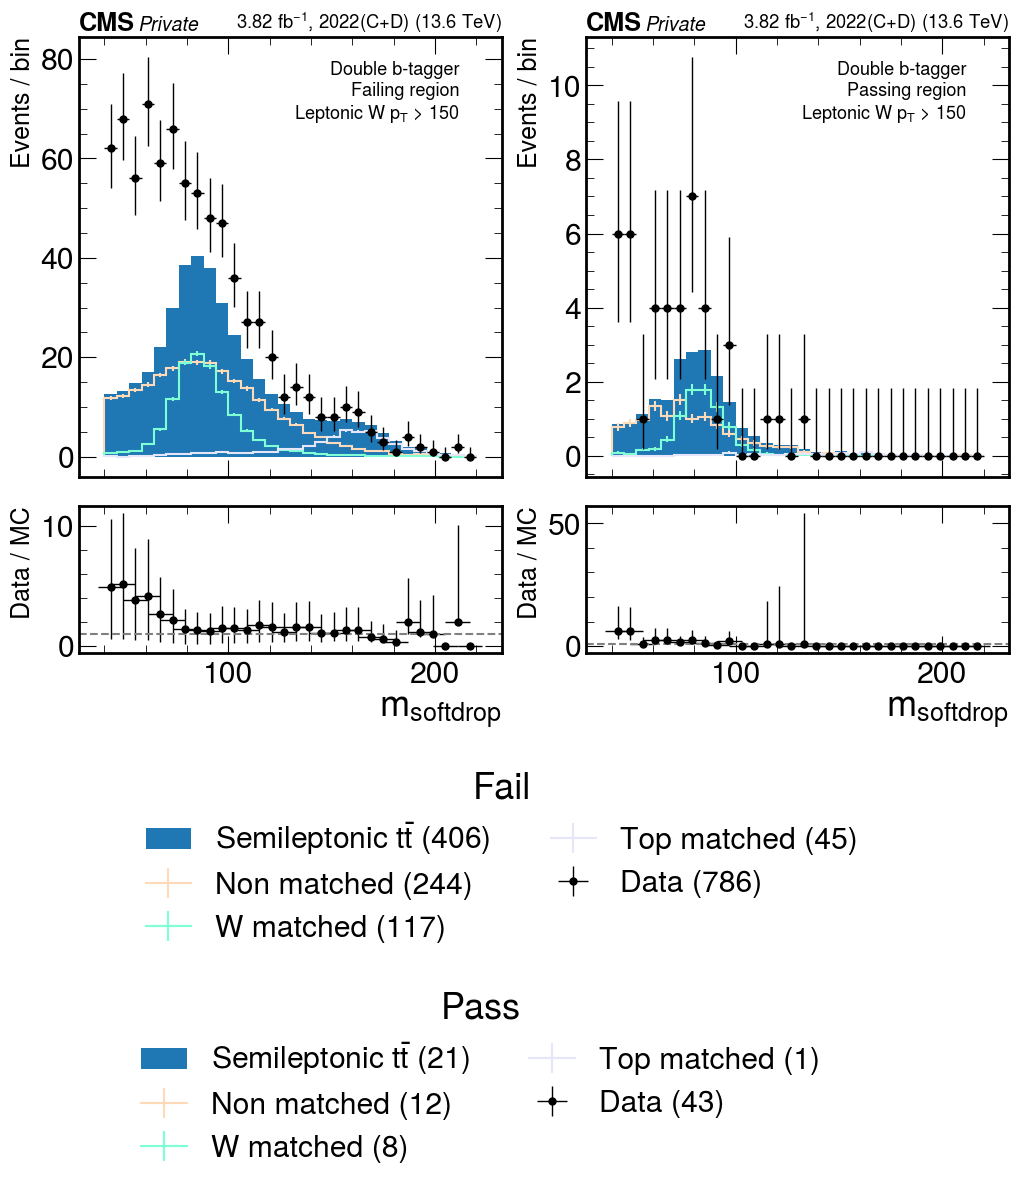

In [82]:
from coffea.hist import clopper_pearson_interval, poisson_interval

#data = util.load("outfiles/Run3Summer22/fulllumi/nminus1_Run2022C_jetId_btag0p1.coffea")[0]
mc = util.load("outfiles/Run3Summer22/fulllumi/nminus1_TTtoLNu2Q_isoTrack_jetId_btag0p1.coffea")[0]

lumis = {
    "2022d" :  3820.82926407 #1179.99079713  #2640.83846694
}

scale = 0.47837295482 #0.45444947223 #0.48906250969

xs = {
    "TTtoLNu2Q" : 762.1,
    "QCD" : 222.1,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
    'Muon track dz',
]

region = {
    0 : "Failing region",
    1 : "Passing region",
}

hist_data = {}
hist_mc = {}

scale_lumi_mc = {k: xs[k] * lumis[era] * scale / w for k, w in mc['sumw'].items()}

h_data = data[{
    "cat" : sum,
    "process" : sum,
    "region" : hist.loc("all")
}]
h_mc = mc["cutflow"][{
    "region" : hist.loc("all")
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi[name]
    
for i in [5]: #h_mc.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 2, figsize=(12, 8), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    
    for j, r in enumerate(["fail", "pass"]):
    
        fig.subplots_adjust(hspace=0.1)
        ax[j].set_ylabel("Events / bin" if j == 0 else " ")
        rax[j].set_ylabel("Data / MC" if j == 0 else " ")
        rax[j].set_xlabel(r"m$_{softdrop}$")
        ax[j].set_xlabel(" ")

        sli = slice(0j, 0.05j, sum) if j == 0 else slice(0.05j, 1j, sum)
        hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i), "pn_Hbb" : sli}]
        hist_mc[r] = hh_mc
    
        mplhep.histplot(
            [
                hh_mc[{"cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}],
            ],
            ax=ax[j], 
            histtype="fill",
            label=[
                r"Semileptonic $t\bar{t}$" + f" ({hh_mc.sum().value:,.0f})",
            ],
            stack=True,
            sort="y_r",
        )

        mplhep.histplot(
            [
                hh_mc[{"cat" : hist.loc(3)}],
                hh_mc[{"cat" : hist.loc(2)}],
                hh_mc[{"cat" : hist.loc(1)}],
            ],
            ax=ax[j],
            label=[
                "Non matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc(3)}].sum().value),
                "W matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc(2)}].sum().value),
                "Top matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc(1)}].sum().value),
            ],
            color=["peachpuff","aquamarine","lavender"]
        )

        hh_data = h_data[{"cut" : hist.loc(i), "pn_Hbb" : sli}]
        hist_data[r] = hh_data

        mplhep.histplot(
            hh_data, 
            ax=ax[j], 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data ({hh_data.sum().value:,.0f})"
        )

        centers = hh_data.axes[0].centers
        sumw_num, sumw2_num = hh_data.values(), hh_data.variances()
        sumw_denom, sumw2_denom = hh_mc[{"cat" : sum}].values(), hh_mc[{"cat" : sum}].variances()

        rsumw = sumw_num / np.maximum(1, sumw_denom)
        rsumw_unc = poisson_interval(
            rsumw,
            sumw2_num / sumw_denom**2
        )

        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }

        rax[j].errorbar(
            centers,
            rsumw,
            xerr=centers[1]-centers[0],
            yerr=rsumw_unc,
            **data_err_opts,
        )

        rax[j].axhline(1, color='gray',ls='--')

        plt.text(0.9, 0.8, f"Double b-tagger\n{region[j]}\n{cuts[i]}",
                    fontsize=13,
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    transform=ax[j].transAxes
                   )

        mplhep.cms.label(
            ax=ax[j], 
            data=True, 
            label="Private",
            year="2022(C+D)",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
            fontsize=14,
        )
        
        ax[j].set_ylabel("Events / bin", fontsize=18)
        rax[j].set_ylabel("Data / MC", fontsize=18)

    ax[0].legend(loc='upper center', title="Fail", bbox_to_anchor=(1, -0.6), ncol=2)
    ax[1].legend(loc='upper center', title="Pass", bbox_to_anchor=(-0.25, -1.1), ncol=2)

/tmp/ipykernel_28/3410856014.py:106: RuntimeWarning: invalid value encountered in divide
  sumw2_num / sumw_denom**2


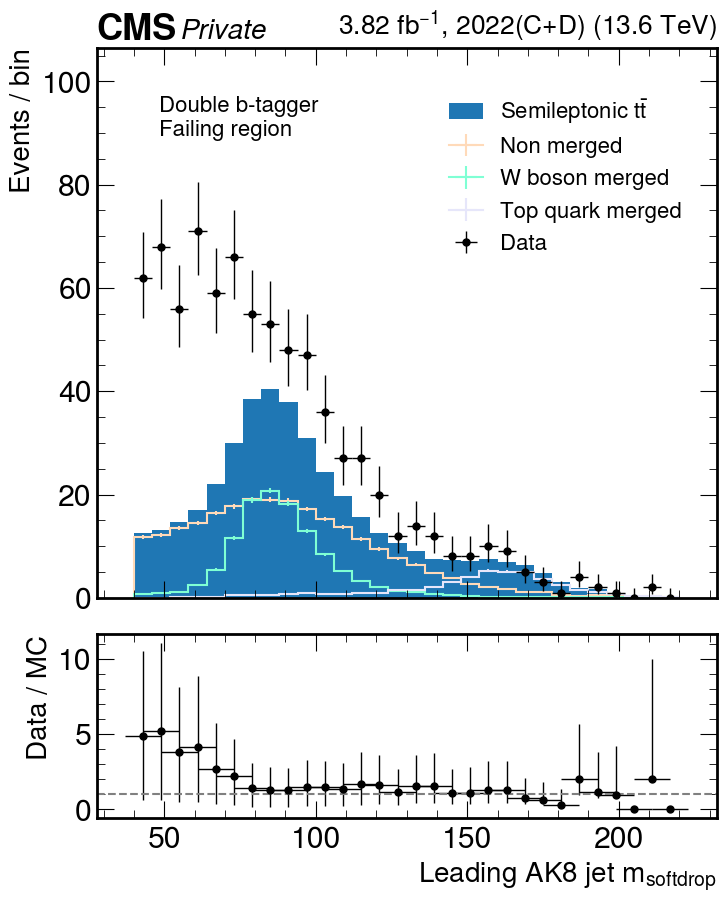

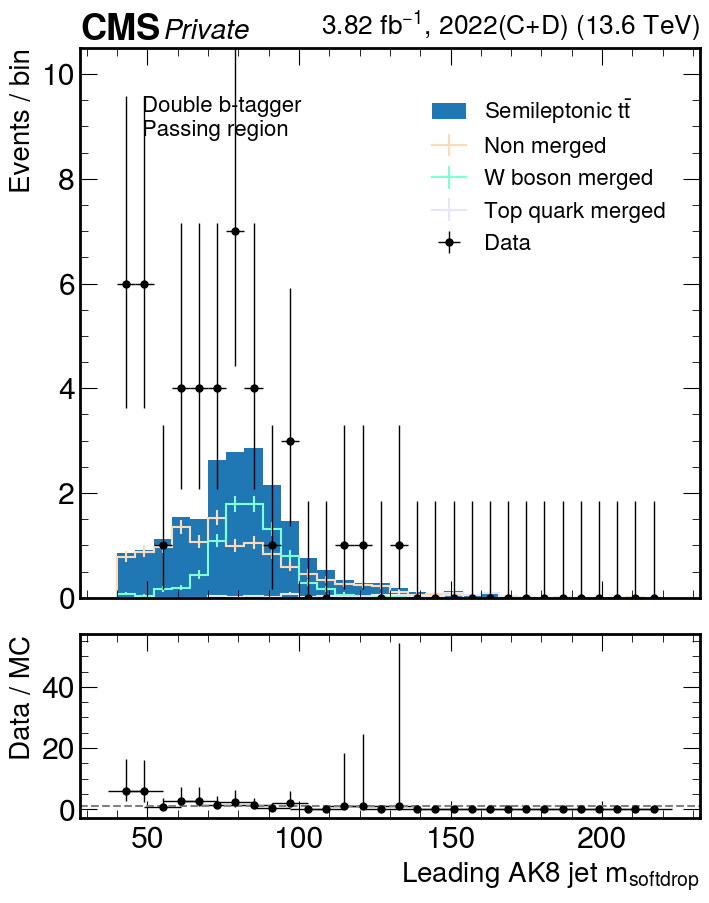

In [85]:
from coffea.hist import clopper_pearson_interval, poisson_interval

#data = util.load("outfiles/Run3Summer22/fulllumi/nminus1_Run2022C_jetId_btag0p1.coffea")[0]
mc = util.load("outfiles/Run3Summer22/fulllumi/nminus1_TTtoLNu2Q_isoTrack_jetId_btag0p1.coffea")[0]

lumis = {
    "2022d" :  3820.82926407 #1179.99079713  #2640.83846694
}

scale = 0.47837295482 #0.45444947223 #0.48906250969

xs = {
    "TTtoLNu2Q" : 762.1,
    "QCD" : 222.1,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
    'Muon track dz',
]

region = {
    0 : "Failing region",
    1 : "Passing region",
}

hist_data = {}
hist_mc = {}

scale_lumi_mc = {k: xs[k] * lumis[era] * scale / w for k, w in mc['sumw'].items()}

h_data = data[{
    "cat" : sum,
    "process" : sum,
    "region" : hist.loc("all")
}]
h_mc = mc["cutflow"][{
    "region" : hist.loc("all")
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi[name]
    
for i in [5]:
    
    for j, r in enumerate(["fail", "pass"]):
        
        fig, (ax, rax) = plt.subplots(
            2, 1, figsize=(8, 10), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
        )
        fig.subplots_adjust(hspace=0.1)

        sli = slice(hist.underflow, 1, sum) if j == 0 else slice(1, hist.overflow, sum)
        hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i), "pn_Hbb" : sli}]
        hist_mc[r] = hh_mc

        mplhep.histplot(
            hh_mc[{"cat" : sum}],
            ax=ax, 
            histtype="fill",
            label=r"Semileptonic $t\bar{t}$",
        )

        mplhep.histplot(
            [
                hh_mc[{"cat" : hist.loc(3)}],
                hh_mc[{"cat" : hist.loc(2)}],
                hh_mc[{"cat" : hist.loc(1)}],
            ],
            ax=ax,
            label=[
                "Non merged",
                "W boson merged",
                "Top quark merged",
            ],
            color=["peachpuff","aquamarine","lavender"]
        )

        hh_data = h_data[{"cut" : hist.loc(i), "pn_Hbb" : sli}]
        hist_data[r] = hh_data

        mplhep.histplot(
            hh_data, 
            ax=ax, 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data"
        )

        centers = hh_data.axes[0].centers
        sumw_num, sumw2_num = hh_data.values(), hh_data.variances()
        sumw_denom, sumw2_denom = hh_mc[{"cat" : sum}].values(), hh_mc[{"cat" : sum}].variances()

        rsumw = sumw_num / np.maximum(1, sumw_denom)
        rsumw_unc = poisson_interval(
            rsumw,
            sumw2_num / sumw_denom**2
        )

        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }
        
        ax.set_ylim([0, max(hh_data.values()) * 1.5])

        rax.errorbar(
            centers,
            rsumw,
            xerr=centers[1]-centers[0],
            yerr=rsumw_unc,
            **data_err_opts,
        )

        rax.axhline(1, color='gray',ls='--')

        plt.text(0.1, 0.83, f"Double b-tagger\n{region[j]}", #"\n{cuts[i]}",
                    fontsize=16,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )

        mplhep.cms.label(
            ax=ax, 
            data=True, 
            label="Private",
            year="2022(C+D)",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
            fontsize=20,
        )
        
        ax.set_ylabel("Events / bin", fontsize=20)
        rax.set_ylabel("Data / MC", fontsize=20)
        rax.set_xlabel(r"Leading AK8 jet $m_{softdrop}$", fontsize=20)
        ax.set_xlabel(" ")
        
        ax.legend(loc='best', fontsize=16, bbox_to_anchor=(0.98, 0.95))

In [91]:
import uproot

cat = {
    "non_matched": 3, 
    "w_matched": 2,
    "top_matched": 1
}

with uproot.recreate("outfiles/Run3Summer22/fulllumi/histograms.root") as fout:
    for region in ["fail", "pass"]:
        fout[f"data_obs_{region}_nominal"] = hist_data[region]

        for matched in ["non_matched", "w_matched", "top_matched"]:
            fout[f"{matched.split('_')[0]}_{region}_nominal"] = hist_mc[region][{"cat" : hist.loc(cat[matched])}]

In [92]:
with uproot.open("outfiles/Run3Summer22/fulllumi/histograms.root") as fin:
    for key, value in fin.items():
        print(key)

data_obs_fail_nominal;1
non_fail_nominal;1
w_fail_nominal;1
top_fail_nominal;1
data_obs_pass_nominal;1
non_pass_nominal;1
w_pass_nominal;1
top_pass_nominal;1


In [71]:
import os, sys
import subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util
import pickle


campaign = "Run3Summer22"
indir = f"outfiles/{campaign}"
infiles = ["outfiles/Run3Summer22/cutflow_QCD.coffea", "outfiles/Run3Summer22/cutflow_TTtoLNu2Q.coffea"]
#subprocess.getoutput(f"ls {indir}/cutflow_*.coffea --ignore {indir}/cutflow_Run2022D.coffea").split()
outsum = processor.dict_accumulator()

# Check if pickle exists, remove it if it does
picklename = f"outfiles/{campaign}/templates.pkl"
if os.path.isfile(picklename):
    os.remove(picklename)

for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if type(out) == tuple:
                out = out[0]
                
        process = out["cutflow"].axes["dataset"][0]
        
        outsum[process] = out['cutflow']
        #outsum['sumw'] = out['sumw']

        del out

Loading outfiles/Run3Summer22/cutflow_QCD.coffea
Loading outfiles/Run3Summer22/cutflow_TTtoLNu2Q.coffea


In [66]:
qcd = util.load("outfiles/Run3Summer22/cutflow_QCD.coffea")

In [88]:
ttbar = util.load("outfiles/Run3Summer22/cutflow_TTtoLNu2Q.coffea")

In [91]:
ttbar["cutflow"] + ttbar["cutflow"]

Hist(
  StrCategory(['TTtoLNu2Q'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['nan', 'non_matched', 'w_matched', 'top_matched'], growth=True, name='cat', label='Category'),
  Regular(50, 40, 220, name='msoftdrop'),
  Regular(50, 150, 700, name='pt', label='$p_T$'),
  Regular(50, 0, 1, name='pn_Hbb', label='H(bb) vs QCD score'),
  IntCategory([0, 1, 2, 3, 4, 5, 6, 7], growth=True, name='cut', label='Cut Idx'),
  storage=Weight()) # Sum: WeightedSum(value=6.02243e+08, variance=2.07613e+11) (WeightedSum(value=4.51744e+10, variance=1.53638e+13) with flow)

In [92]:
ttbar["cutflow"]

Hist(
  StrCategory(['TTtoLNu2Q'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['nan', 'non_matched', 'w_matched', 'top_matched'], growth=True, name='cat', label='Category'),
  Regular(50, 40, 220, name='msoftdrop'),
  Regular(50, 150, 700, name='pt', label='$p_T$'),
  Regular(50, 0, 1, name='pn_Hbb', label='H(bb) vs QCD score'),
  IntCategory([0, 1, 2, 3, 4, 5, 6, 7], growth=True, name='cut', label='Cut Idx'),
  storage=Weight()) # Sum: WeightedSum(value=3.01121e+08, variance=1.03807e+11) (WeightedSum(value=2.25872e+10, variance=7.68188e+12) with flow)

In [ ]:
scale_lumi = {k: xs[k] * 1000 * lumis[year] / w for k, w in outsum['sumw'].items()} 

outsum['templates'].scale(scale_lumi, 'dataset')

print(outsum['templates'].identifiers('dataset'))

templates = outsum['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)

del outsum

outfile = open(picklename, 'wb')
pickle.dump(template

In [116]:
from coffea.hist import clopper_pearson_interval, poisson_interval
import pandas as pd

data = util.load("outfiles/Run3Summer22/lumi25000hltmu50/cutflow_Run2022D_HLT_Mu50_noCHS.coffea")
mc = util.load("outfiles/Run3Summer22/lumi100isoTrack/cutflow_TTtoLNu2Q_isoTrack.coffea")

lumis = {
    "2022d" :  1624.917355479 #986.530469663 #624.905199074
}
xs = {
    "TTtoLNu2Q" : 762.1,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
    'Muon track dz',
]

region = {
    0 : "Failing region",
    1 : "Passing region",
}

def most_prob(h):
    highest = np.argmax(h.values())
    return h.axes[0].centers[highest]

hist_data = {}
hist_mc = {}

scale_lumi = {k: xs[k] * lumis[era] / w for k, w in mc['sumw'].items()}
    
h_data = data["cutflow"][{
    "cat" : sum,
    "dataset" : sum,
}]
h_mc = mc["cutflow"]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi[name]


for i in h_mc.axes["cut"]:
    
    df = pd.DataFrame([])
    df.index = ["Non prob.", "Non res.", "Non #", "W prob.", "W res.", "W #", "Top prob.", "Top res.", "Top #",]

    smallest_res = 220
    smallest_res_cut = 0
    
    for j, cut in enumerate(h_mc.axes["pn_Hbb"].centers):
    
        passing = slice(j, 1j, sum)
        values = []
        
        for k, merged in {3: "Non-merged", 2: "Merged W boson", 1: "Merged top quark"}.items():
            
            hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i), "pn_Hbb" : passing, "cat" : hist.loc(k)}]
            
            values.append(most_prob(hh_mc))
            res = resolution(hh_mc, wmax=220, wmin=40)
            values.append(res)
            values.append(hh_mc.sum().value)
            
            if k == 2:
                if res < smallest_res:
                    smallest_res = res
                    smallest_res_cut = cut
            
        df[cut] = values
        
    print(f"{cuts[i]} - cut with smallest W res.: {smallest_res_cut}")
    display(df.style.format("{:,.1f}"))

Nothing - cut with smallest W res.: 0.05


,0.016667,0.050000,0.083333,0.116667,0.150000,0.183333,0.216667,0.250000,0.283333,0.316667,0.350000,0.383333,0.416667,0.450000,0.483333,0.516667,0.550000,0.583333,0.616667,0.650000,0.683333,0.716667,0.750000,0.783333,0.816667,0.850000,0.883333,0.916667,0.950000,0.983333
Non prob.,67.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
Non res.,24.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
Non #,"1,035.8",59.7,58.7,58.1,57.5,57.0,56.5,56.2,55.7,55.4,54.9,54.6,54.2,53.6,53.1,52.7,52.4,51.9,51.4,51.0,50.4,49.9,49.4,48.8,47.9,47.0,46.0,44.8,43.3,40.6
W prob.,85.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0
W res.,90.0,15.0,21.0,21.0,15.0,15.0,24.0,15.0,27.0,24.0,24.0,30.0,30.0,27.0,30.0,30.0,33.0,30.0,30.0,27.0,24.0,24.0,24.0,24.0,30.0,90.0,90.0,90.0,90.0,30.0
W #,402.7,26.6,26.2,26.0,25.8,25.5,25.4,25.3,25.1,24.9,24.8,24.7,24.5,24.4,24.2,24.1,23.9,23.7,23.4,23.2,22.9,22.6,22.4,22.2,21.8,21.4,21.0,20.3,19.3,18.0
Top prob.,157.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0
Top res.,27.0,90.0,39.0,39.0,39.0,39.0,39.0,39.0,36.0,39.0,36.0,39.0,39.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,39.0,36.0
Top #,94.1,1.6,1.5,1.5,1.5,1.5,1.5,1.5,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.3,1.3,1.2,1.2,1.2,1.2


HLT_Mu50 - cut with smallest W res.: 0.05


,0.016667,0.050000,0.083333,0.116667,0.150000,0.183333,0.216667,0.250000,0.283333,0.316667,0.350000,0.383333,0.416667,0.450000,0.483333,0.516667,0.550000,0.583333,0.616667,0.650000,0.683333,0.716667,0.750000,0.783333,0.816667,0.850000,0.883333,0.916667,0.950000,0.983333
Non prob.,67.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
Non res.,24.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
Non #,"1,008.1",58.3,57.4,56.8,56.2,55.7,55.3,54.9,54.5,54.1,53.7,53.4,53.0,52.4,51.9,51.6,51.2,50.8,50.3,49.8,49.3,48.8,48.3,47.8,46.9,46.0,45.0,43.9,42.4,39.8
W prob.,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0
W res.,90.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,24.0,24.0,24.0,27.0,27.0,24.0,27.0,27.0,30.0,30.0,27.0,15.0,21.0,15.0,15.0,15.0,15.0,15.0,90.0,90.0,15.0,24.0
W #,391.4,26.2,25.9,25.6,25.4,25.2,25.0,24.9,24.7,24.6,24.4,24.3,24.1,24.0,23.8,23.7,23.5,23.3,23.0,22.8,22.6,22.3,22.1,21.8,21.5,21.1,20.7,20.1,19.1,17.7
Top prob.,157.0,163.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0
Top res.,27.0,90.0,39.0,39.0,39.0,39.0,39.0,39.0,39.0,39.0,36.0,39.0,39.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,39.0,36.0
Top #,91.3,1.5,1.5,1.5,1.4,1.4,1.4,1.4,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.2,1.2,1.2,1.2,1.1


AK8 jet p$_T$ > 200 - cut with smallest W res.: 0.016666666666666666


,0.016667,0.050000,0.083333,0.116667,0.150000,0.183333,0.216667,0.250000,0.283333,0.316667,0.350000,0.383333,0.416667,0.450000,0.483333,0.516667,0.550000,0.583333,0.616667,0.650000,0.683333,0.716667,0.750000,0.783333,0.816667,0.850000,0.883333,0.916667,0.950000,0.983333
Non prob.,79.0,61.0,61.0,61.0,61.0,61.0,73.0,61.0,61.0,61.0,73.0,73.0,73.0,61.0,61.0,61.0,73.0,73.0,61.0,61.0,61.0,61.0,73.0,73.0,61.0,61.0,61.0,61.0,61.0,61.0
Non res.,30.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
Non #,740.4,36.5,35.9,35.6,35.3,34.9,34.6,34.4,34.2,34.0,33.7,33.6,33.3,32.9,32.6,32.4,32.2,31.9,31.6,31.3,31.1,30.8,30.4,30.1,29.6,29.0,28.5,27.8,26.8,25.1
W prob.,85.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0
W res.,15.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
W #,327.6,21.5,21.2,20.9,20.7,20.6,20.4,20.4,20.2,20.1,19.9,19.8,19.7,19.6,19.4,19.3,19.1,19.0,18.8,18.6,18.4,18.2,18.0,17.9,17.6,17.2,16.9,16.4,15.6,14.6
Top prob.,157.0,163.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0
Top res.,27.0,42.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,33.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,33.0,33.0,33.0,33.0,33.0,33.0
Top #,90.5,1.4,1.3,1.3,1.3,1.3,1.3,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.1,1.1,1.1,1.1,1.0,1.0


MET $>$ 50 GeV - cut with smallest W res.: 0.016666666666666666


,0.016667,0.050000,0.083333,0.116667,0.150000,0.183333,0.216667,0.250000,0.283333,0.316667,0.350000,0.383333,0.416667,0.450000,0.483333,0.516667,0.550000,0.583333,0.616667,0.650000,0.683333,0.716667,0.750000,0.783333,0.816667,0.850000,0.883333,0.916667,0.950000,0.983333
Non prob.,79.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,61.0,61.0,73.0,73.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
Non res.,30.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0
Non #,495.9,23.6,23.2,23.0,22.8,22.6,22.5,22.3,22.2,22.0,21.8,21.7,21.5,21.2,21.0,20.9,20.7,20.5,20.3,20.2,20.0,19.9,19.6,19.5,19.1,18.8,18.5,18.0,17.5,16.3
W prob.,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,85.0,85.0,85.0,79.0,85.0,79.0,85.0,79.0,79.0,79.0
W res.,18.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
W #,222.2,14.1,13.9,13.8,13.7,13.6,13.6,13.5,13.5,13.4,13.3,13.2,13.1,13.1,13.0,12.9,12.8,12.7,12.5,12.4,12.3,12.0,11.9,11.8,11.7,11.4,11.2,10.9,10.4,9.7
Top prob.,157.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0
Top res.,27.0,30.0,30.0,30.0,30.0,27.0,27.0,27.0,27.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,27.0,30.0,30.0,30.0,27.0,24.0
Top #,71.2,1.1,1.0,1.0,1.0,1.0,1.0,1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.8,0.8


Good muon - cut with smallest W res.: 0.016666666666666666


,0.016667,0.050000,0.083333,0.116667,0.150000,0.183333,0.216667,0.250000,0.283333,0.316667,0.350000,0.383333,0.416667,0.450000,0.483333,0.516667,0.550000,0.583333,0.616667,0.650000,0.683333,0.716667,0.750000,0.783333,0.816667,0.850000,0.883333,0.916667,0.950000,0.983333
Non prob.,79.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,61.0,61.0,73.0,73.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
Non res.,30.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0
Non #,495.9,23.6,23.2,23.0,22.8,22.6,22.5,22.3,22.2,22.0,21.8,21.7,21.5,21.2,21.0,20.9,20.7,20.5,20.3,20.2,20.0,19.9,19.6,19.5,19.1,18.8,18.5,18.0,17.5,16.3
W prob.,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,85.0,85.0,85.0,79.0,85.0,79.0,85.0,79.0,79.0,79.0
W res.,18.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
W #,222.2,14.1,13.9,13.8,13.7,13.6,13.6,13.5,13.5,13.4,13.3,13.2,13.1,13.1,13.0,12.9,12.8,12.7,12.5,12.4,12.3,12.0,11.9,11.8,11.7,11.4,11.2,10.9,10.4,9.7
Top prob.,157.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0,163.0
Top res.,27.0,30.0,30.0,30.0,30.0,27.0,27.0,27.0,27.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,27.0,30.0,30.0,30.0,27.0,24.0
Top #,71.2,1.1,1.0,1.0,1.0,1.0,1.0,1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.8,0.8


Leptonic W p$_T$ > 150 - cut with smallest W res.: 0.05


,0.016667,0.050000,0.083333,0.116667,0.150000,0.183333,0.216667,0.250000,0.283333,0.316667,0.350000,0.383333,0.416667,0.450000,0.483333,0.516667,0.550000,0.583333,0.616667,0.650000,0.683333,0.716667,0.750000,0.783333,0.816667,0.850000,0.883333,0.916667,0.950000,0.983333
Non prob.,79.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,61.0,73.0,73.0,61.0,61.0,61.0,61.0,61.0,61.0
Non res.,30.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,24.0,24.0,24.0,27.0,27.0,27.0,27.0,27.0
Non #,329.5,15.3,15.0,14.8,14.7,14.5,14.5,14.3,14.3,14.2,14.1,14.0,13.8,13.6,13.5,13.4,13.3,13.1,13.0,12.9,12.8,12.7,12.5,12.4,12.2,12.0,11.7,11.4,11.1,10.5
W prob.,85.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0
W res.,15.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
W #,160.5,10.5,10.3,10.3,10.2,10.2,10.1,10.1,10.0,10.0,9.9,9.8,9.8,9.8,9.7,9.6,9.6,9.5,9.4,9.3,9.2,9.0,9.0,8.9,8.8,8.5,8.4,8.1,7.8,7.3
Top prob.,157.0,163.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0
Top res.,24.0,30.0,24.0,24.0,24.0,24.0,24.0,30.0,24.0,24.0,24.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,24.0,24.0,24.0,24.0,24.0,24.0
Top #,57.7,0.9,0.8,0.8,0.8,0.8,0.8,0.8,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7


Same hem. AK4 b-jet - cut with smallest W res.: 0.016666666666666666


/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])

,0.016667,0.050000,0.083333,0.116667,0.150000,0.183333,0.216667,0.250000,0.283333,0.316667,0.350000,0.383333,0.416667,0.450000,0.483333,0.516667,0.550000,0.583333,0.616667,0.650000,0.683333,0.716667,0.750000,0.783333,0.816667,0.850000,0.883333,0.916667,0.950000,0.983333
Non prob.,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
Non res.,33.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
Non #,3.6,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
W prob.,91.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0
W res.,21.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
W #,1.4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Top prob.,145.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
Top res.,27.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
Top #,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Opp. hem. AK8 jet - cut with smallest W res.: 0.016666666666666666


/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])

,0.016667,0.050000,0.083333,0.116667,0.150000,0.183333,0.216667,0.250000,0.283333,0.316667,0.350000,0.383333,0.416667,0.450000,0.483333,0.516667,0.550000,0.583333,0.616667,0.650000,0.683333,0.716667,0.750000,0.783333,0.816667,0.850000,0.883333,0.916667,0.950000,0.983333
Non prob.,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
Non res.,33.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
Non #,3.6,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
W prob.,91.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0
W res.,21.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
W #,1.4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Top prob.,145.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
Top res.,27.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
Top #,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])

Muon track dz - cut with smallest W res.: 0.016666666666666666


/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])
/tmp/ipykernel_62/1542695249.py:18: RuntimeWarning: invalid value encountered in double_scalars
  points.append([centers[i], weight / thesum])


,0.016667,0.050000,0.083333,0.116667,0.150000,0.183333,0.216667,0.250000,0.283333,0.316667,0.350000,0.383333,0.416667,0.450000,0.483333,0.516667,0.550000,0.583333,0.616667,0.650000,0.683333,0.716667,0.750000,0.783333,0.816667,0.850000,0.883333,0.916667,0.950000,0.983333
Non prob.,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
Non res.,33.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
Non #,3.6,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
W prob.,91.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0
W res.,21.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
W #,1.4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Top prob.,145.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
Top res.,27.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
Top #,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
def resolution(h, wmin=0.2, wmax=1.8, epsilon=0.01):

    point = wmin
    weight = 0.0
    points = []
    # number of all jets
    thesum = h.sum().value

    # number of jets in each bin
    values = h.values()

    # bin centers
    centers = h.axes[0].centers

    # fill list of bin centers and the integral up to those points
    for i, value in enumerate(values):
        weight += value
        points.append([centers[i], weight / thesum])

    low = wmin
    high = wmax

    # loop over all possible bin combninations and find the one
    # with smallest width and ~68% of all jets
    width = wmax - wmin
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
#             print(wy)
            if abs(wy - 0.683) < epsilon:
#                 print(f"here {i} and {j}")
                wx = points[j][0] - points[i][0]
#                 print(wx)
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
#                     print(points[j][0], points[i][0], wy, wx)
                    width = wx
#     print(low, high)
    return 0.5 * (high - low)